In [1]:
import numpy as np
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt

**IMPORTANT NOTE**: This handout notebook relies on functions from the **for-this-class-only** `mylib` package. To access this package, clone or download it from **[this GitHub page](https://github.com/aalgahmi/mylib)**. You can find instructions on how to clone this package on its main GitHub page, as well as in the `04.working_with_datasets.ipynb` notebook handout. Make sure to place the `mylib` folder from this package in the same directory as this notebook. Once you've completed this step, the following import should work seamlessly.

In [2]:
import mylib as my

# 08: Regression trees

## A regression tree from scratch
Decisions trees are simple yet powerful learning models. They partition the input space into regions: some with single examples, some with more. We have seen classification decision trees in the previous notebook. In this notebook we implement and test a regression decision tree.

This implementation mainly shows two main things:

* how to handle continuous features
* how to report continuous output (thus the name regression tree)

Because a continuous feature by definition can have too many possible values, these values cannot be used as branches. It cannot just be used for only one node (or split) like we saw with discrete features in the previous decision tree notebook. Instead, it is used multiple times, each using a different threshold value.

Our implementation will result in binary decision tree where a feature can be used at multiple split nodes. It is the job of the implementation to find out the "best" threshold values to split at. But "best" based on what? Well, we cannot use the entropy or the gini index here. Instead we will use variance (from statistics) as a measure of impurity.

### Using variance and variance reduction

Given a set of examples $D$ with a continuous output $y$, we define the variance of $y$ as:

$${\displaystyle \mathrm {V(D)}= var(y) = \frac{1}{|D|} \sum_i^{|D|} (y_i - \bar{y})^2}$$

where $\bar{y}$ is the mean of $y$. We use this variance as a measure of impurity. Zero variance corresponds to pure nodes where all the output values are the same. 

Like the situation between entropy and information gain, we are interested here in the reduction in variance caused by splitting the data based a continuous feature $F$ at a threshold value $t$. Such reduction is defined as :

$${\displaystyle \operatorname {Reduction(D, F, t)} =V(D) - [\frac{|D_{F \le t}|}{|D|}V(D_{F \le t}) + \frac{|D_{F > t}|}{|D|}V(D_{F > t}]}$$

Here the best split threshold corresponds to the least variance reduction. 

### Constructing the tree

We simply calculate the variance reduction for all possible threshold values of all continuous features and pick the one with the most variance reduction to be our root node. We then recursively repeat the same calculations on both the left hand side of the threshold and the right hand side of the threshold. 

Prediction using this tree involves traversing the tree using the feature values of the unseen example. If a leaf node is reached and there are more than one examples under it, the mean of those examples is return as the prediction outcome. 

Here is how such implementation looks:

In [3]:
class RegressionDecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        
    def fit(self, X, y, indices = None):
        self.X = X if X.ndim > 1 else X.reshape(-1, 1)
        self.M = self.X.shape[1]
        self.y = y
        self.ds = my.to_dataframe(X, y)
        
        if indices is None: 
            indices=np.arange(len(self.y))
            
        self.indices = indices
        self.root = self.Node(self, self.indices, 0)
        
        return self
    
    def output_value(self, y):
        return np.mean(y)
    
    def best_feature_split(self, node, feature_index):
        """
        When called on all the features, it finds the best feature to 
        split by and at what threshold. 
        
        NOTE that: lhs = left hand side and rhs = right hand side
        """
        X, y = self.X[node.indices,feature_index], self.y[node.indices]
        var_d = np.var(y)
        d = len(y)
        
        """Let us sort the feature values"""
        sort_idxs = np.argsort(X)
        sorted_X, sorted_y = X[sort_idxs], y[sort_idxs]

        for i in range(0, node.N - 1):
            xi,yi = sorted_X[i],sorted_y[i]
            
            if i < 2 or xi == sorted_X[i + 1]:
                continue
            
            d_lhs = len(y[np.nonzero(X <= xi )])
            d_rhs = len(y[np.nonzero(X > xi )])
            
            var_lhs = np.var(y[np.nonzero(X <= xi )])
            var_rhs = np.var(y[np.nonzero(X > xi )])
            var_reduction = var_d - ((d_lhs / d) * var_lhs + (d_rhs / d) * var_rhs)            
                            
            if var_reduction > node.split_var_reduction: 
                node.split_feature_index = feature_index
                node.split_var_reduction = var_reduction
                node.split_threshold = xi
                
    def print_tree(self, node=None):
        if node is None: node = self.root
        print(repr(node))
        if node.left: self.print_tree(node.left)
        if node.right: self.print_tree(node.right)

    def predict(self, X_unseen, node=None):
        if X_unseen.ndim == 1:
            if node is None:
                node = self.root
                
            if node.is_leaf: return node.value
            node = node.left if X_unseen[node.split_feature_index] <= node.split_threshold else node.right
            return self.predict(X_unseen, node)
        else:
            return np.array([self.predict(ex) for ex in X_unseen])
            # return np.array([self.predict(X_unseen[i,]) for i in range(len(X_unseen))]) 
        
    class Node:
        """
        An internal class representing the nodes of the tree.
        """
        def __init__(self, tree, indices, depth):
            self.tree, self.indices, self.depth = tree, indices, depth            
            self.N, self.M = len(self.indices), self.tree.X.shape[1]
            self.value = self.tree.output_value(self.tree.y[self.indices])
            self.split_feature_index = 0
            self.split_var_reduction = 0
            self.left, self.right = None, None
            
            if tree.max_depth is not None and tree.max_depth == depth:
                return
            
            """
            Find the best split across all features(dimentions) based on the minimum
            variance reduction.
            """
            for feature_index in range(self.M): 
                self.tree.best_feature_split(self, feature_index)
                
            if self.split_var_reduction == 0: 
                return

            feature = self.tree.X[self.indices, self.split_feature_index]

            """Binary branching based on the best found feature and threshold."""
            lhs_indices = np.nonzero(feature <= self.split_threshold)[0]
            rhs_indices = np.nonzero(feature > self.split_threshold)[0]
            
            self.left = self.tree.Node(self.tree, self.indices[lhs_indices], self.depth + 1)
            self.right= self.tree.Node(self.tree, self.indices[rhs_indices], self.depth + 1)

        @property
        def split_name(self): 
            return self.tree.ds.columns[self.split_feature_index]

        @property
        def is_leaf(self): 
            return self.left is None and self.right is None

        @property
        def is_root(self): 
            return self == self.tree.root
           
        def __repr__(self):
            out = f'|{"  |" * self.depth}'
            if not self.is_leaf:
                out += f'--- {self.split_name} { "<=" if self.value <= self.split_threshold else ">"} {self.split_threshold: .2f}'
            else:
                out += f'Leaf value: {self.value: .2f}'
                
            return out

This implementation has a `max_depth` hyperparameter that be used limit the depth of the tree, which is a measure for preventing the tree from overfitting.

## An example: Comparison with SciKit Learn's DecisionTreeRegressor

Let's test the implementation above and compare it to that of SciKit Learn. We start with the following function:

$$y = sin(3\pi x) + cos (4 \pi x) $$

and we add a small random noise to it. Let's use this function to generate and plot some data. We'll use values for $x$ from the interval $[0, 2]$. 

Text(0, 0.5, 't')

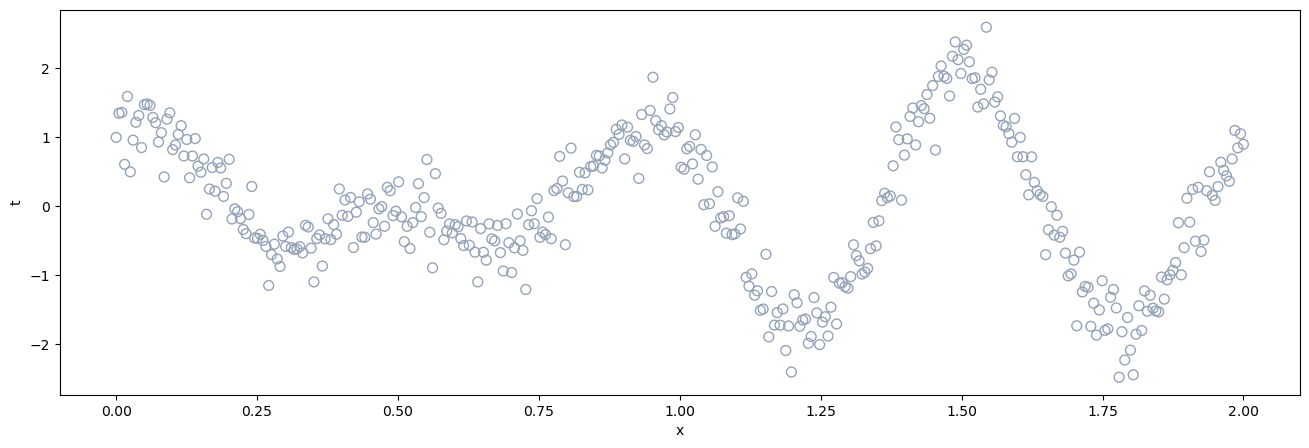

In [4]:
N = 400
x = np.linspace(0,2,N)
t = np.sin(3*np.pi*x) + np.cos(4*np.pi*x) + np.random.randn(N)*.3

fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x, t, s=50, facecolors='none', edgecolors='#94a3b8')
ax.set_xlabel('x')
ax.set_ylabel('t')

The goal here is to use a regression tree model to learn this function (capture its ups and downs) and approximate it. Toward that end, let's take this data and split it into training and test datasets.

In [5]:
X, y, features, target = my.from_dataframe(pd.DataFrame({'x': x, 'y': t}))
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = my.train_test_split(X, y, test_size=.25)

(400, 1) (400,)


We now  create two regression tree models: one using the implementation above and another using SciKit Learn. 

In [6]:
scratch_rdt = RegressionDecisionTree()
sklearn_rdt = tree.DecisionTreeRegressor()

Let's train these models:

In [7]:
scratch_rdt.fit(X_train, y_train)
sklearn_rdt.fit(X_train, y_train)

DecisionTreeRegressor()

Here is the constructed tree of the first from-scratch model:

In [8]:
scratch_rdt.print_tree()

|--- x1 <=  1.64
|  |--- x1 <=  1.37
|  |  |--- x1 <=  1.11
|  |  |  |--- x1 >  0.16
|  |  |  |  |--- x1 >  0.12
|  |  |  |  |  |--- x1 >  0.07
|  |  |  |  |  |  |--- x1 >  0.05
|  |  |  |  |  |  |  |--- x1 >  0.01
|  |  |  |  |  |  |  |  |Leaf value:  1.24
|  |  |  |  |  |  |  |  |--- x1 >  0.04
|  |  |  |  |  |  |  |  |  |Leaf value:  0.89
|  |  |  |  |  |  |  |  |  |Leaf value:  1.08
|  |  |  |  |  |  |  |--- x1 >  0.06
|  |  |  |  |  |  |  |  |Leaf value:  1.47
|  |  |  |  |  |  |  |  |Leaf value:  1.25
|  |  |  |  |  |  |--- x1 >  0.09
|  |  |  |  |  |  |  |Leaf value:  0.87
|  |  |  |  |  |  |  |Leaf value:  1.19
|  |  |  |  |  |--- x1 >  0.14
|  |  |  |  |  |  |Leaf value:  0.89
|  |  |  |  |  |  |Leaf value:  0.59
|  |  |  |  |--- x1 <=  0.77
|  |  |  |  |  |--- x1 <=  0.20
|  |  |  |  |  |  |--- x1 >  0.18
|  |  |  |  |  |  |  |Leaf value:  0.25
|  |  |  |  |  |  |  |Leaf value:  0.62
|  |  |  |  |  |  |--- x1 <=  0.39
|  |  |  |  |  |  |  |--- x1 <=  0.24
|  |  |  |  |  |  | 

And here is the SciKit Learn's tree: 

In [9]:
print(tree.export_text(sklearn_rdt))

|--- feature_0 <= 1.65
|   |--- feature_0 <= 1.38
|   |   |--- feature_0 <= 1.12
|   |   |   |--- feature_0 <= 0.16
|   |   |   |   |--- feature_0 <= 0.12
|   |   |   |   |   |--- feature_0 <= 0.07
|   |   |   |   |   |   |--- feature_0 <= 0.05
|   |   |   |   |   |   |   |--- feature_0 <= 0.02
|   |   |   |   |   |   |   |   |--- feature_0 <= 0.00
|   |   |   |   |   |   |   |   |   |--- value: [1.00]
|   |   |   |   |   |   |   |   |--- feature_0 >  0.00
|   |   |   |   |   |   |   |   |   |--- feature_0 <= 0.01
|   |   |   |   |   |   |   |   |   |   |--- value: [1.35]
|   |   |   |   |   |   |   |   |   |--- feature_0 >  0.01
|   |   |   |   |   |   |   |   |   |   |--- value: [1.36]
|   |   |   |   |   |   |   |--- feature_0 >  0.02
|   |   |   |   |   |   |   |   |--- feature_0 <= 0.03
|   |   |   |   |   |   |   |   |   |--- value: [0.50]
|   |   |   |   |   |   |   |   |--- feature_0 >  0.03
|   |   |   |   |   |   |   |   |   |--- feature_0 <= 0.04
|   |   |   |   |   |   |   

As you can see, both models are large, deep, and complex trees. Let's see how these models perform side by side on both the training and testing sets.

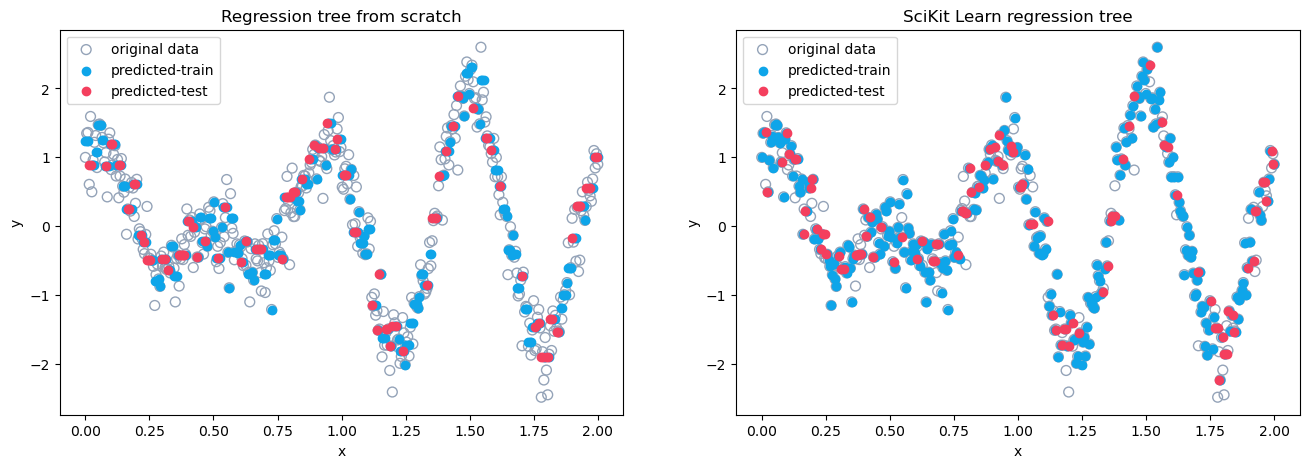

In [10]:
learners = [scratch_rdt, sklearn_rdt]
titles = ["Regression tree from scratch", "SciKit Learn regression tree"]

fig, axes = plt.subplots(1, 2, figsize=(16,5))

for i in range(2):
    axes[i].scatter(x, y, s=50, facecolors='none', edgecolors='#94a3b8', label="original data")

    # Using training data
    axes[i].scatter(X_train, learners[i].predict(X_train), color='#0ea5e9', label="predicted-train")

    # Using testing data
    axes[i].scatter(X_test, learners[i].predict(X_test), color='#f43f5e', label="predicted-test")

    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    axes[i].set_title(titles[i])
    axes[i].legend()

You can see how well these models did in approximating this function. The predicted training outcomes are very close to the actual ones which is understandable since that is the data the model was trained on. The predicted test outcomes are close too.

Because of the complexity of these trees, they may be overfitting. One way of countering overfitting in decision trees is to limit the depth of the tree to a certain `max_depth` value. To see how that works, we need a new measure for training and testing errors. We'll use an L2 loss defined as: 
$$ L2\ loss = \frac{1}{N} \sum_{i=1}^N (actual - predicted)^2$$

In [11]:
def l2_loss(actual, predicted):
    return np.sum((actual - predicted)**2) / len(actual)

We not plot the training and testing errors side by side for a range of `max_depth` values: 1 to 20.

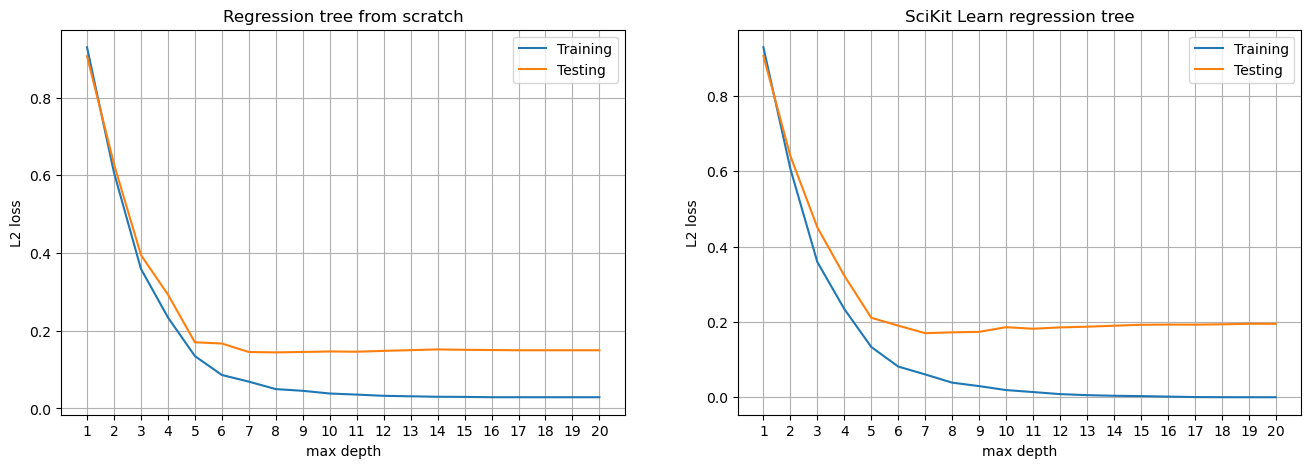

In [12]:
depths = range(1,21)
train_errors = [[], []]
test_errors = [[], []]

learners = [RegressionDecisionTree, tree.DecisionTreeRegressor]
for i in range(2):
    for d in depths:
        rdt = learners[i](max_depth=d).fit(X_train, y_train)
        train_errors[i].append(l2_loss(y_train, rdt.predict(X_train)))
        test_errors[i].append(l2_loss(y_test, rdt.predict(X_test)))
    
# Plotting the curves
titles = ["Regression tree from scratch", "SciKit Learn regression tree"]
fig, axes = plt.subplots(1, 2, figsize=(16,5))

for i in range(2):
    axes[i].plot(depths, train_errors[i], label="Training") 
    axes[i].plot(depths, test_errors[i], label="Testing") 
    axes[i].set_xticks(np.arange(1, 21, 1))
    axes[i].set_xlabel('max depth')
    axes[i].set_ylabel('L2 loss')
    axes[i].set_title(titles[i])
    axes[i].grid()
    axes[i].legend()

From the above curves, the best test results happen when `max_depth` is around 6 or 7 (because of the added random noise, these numbers might change slightly from one run to another). Let's create new models with this value

In [13]:
best_scratch_rdt = RegressionDecisionTree(max_depth=6)
best_sklearn_rdt = tree.DecisionTreeRegressor(max_depth=6)

Let's train these models:

In [14]:
best_scratch_rdt.fit(X_train, y_train)
best_sklearn_rdt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6)

Here is the constructed tree of the first from-scratch model:

In [15]:
best_scratch_rdt.print_tree()

|--- x1 <=  1.64
|  |--- x1 <=  1.37
|  |  |--- x1 <=  1.11
|  |  |  |--- x1 >  0.16
|  |  |  |  |--- x1 >  0.12
|  |  |  |  |  |--- x1 >  0.07
|  |  |  |  |  |  |Leaf value:  1.19
|  |  |  |  |  |  |Leaf value:  1.03
|  |  |  |  |  |--- x1 >  0.14
|  |  |  |  |  |  |Leaf value:  0.89
|  |  |  |  |  |  |Leaf value:  0.59
|  |  |  |  |--- x1 <=  0.77
|  |  |  |  |  |--- x1 <=  0.20
|  |  |  |  |  |  |Leaf value:  0.40
|  |  |  |  |  |  |Leaf value: -0.33
|  |  |  |  |  |--- x1 <=  1.04
|  |  |  |  |  |  |Leaf value:  0.86
|  |  |  |  |  |  |Leaf value: -0.14
|  |  |  |--- x1 <=  1.30
|  |  |  |  |--- x1 <=  1.28
|  |  |  |  |  |--- x1 <=  1.15
|  |  |  |  |  |  |Leaf value: -1.13
|  |  |  |  |  |  |Leaf value: -1.62
|  |  |  |  |  |--- x1 <=  1.30
|  |  |  |  |  |  |Leaf value: -1.14
|  |  |  |  |  |  |Leaf value: -1.02
|  |  |  |  |--- x1 <=  1.35
|  |  |  |  |  |--- x1 <=  1.34
|  |  |  |  |  |  |Leaf value: -0.77
|  |  |  |  |  |  |Leaf value: -0.40
|  |  |  |  |  |Leaf value:  0.12


And here is the SciKit Learn's tree: 

In [16]:
print(tree.export_text(best_sklearn_rdt))

|--- feature_0 <= 1.65
|   |--- feature_0 <= 1.38
|   |   |--- feature_0 <= 1.12
|   |   |   |--- feature_0 <= 0.16
|   |   |   |   |--- feature_0 <= 0.12
|   |   |   |   |   |--- feature_0 <= 0.07
|   |   |   |   |   |   |--- value: [1.19]
|   |   |   |   |   |--- feature_0 >  0.07
|   |   |   |   |   |   |--- value: [1.03]
|   |   |   |   |--- feature_0 >  0.12
|   |   |   |   |   |--- feature_0 <= 0.14
|   |   |   |   |   |   |--- value: [0.89]
|   |   |   |   |   |--- feature_0 >  0.14
|   |   |   |   |   |   |--- value: [0.59]
|   |   |   |--- feature_0 >  0.16
|   |   |   |   |--- feature_0 <= 0.77
|   |   |   |   |   |--- feature_0 <= 0.20
|   |   |   |   |   |   |--- value: [0.40]
|   |   |   |   |   |--- feature_0 >  0.20
|   |   |   |   |   |   |--- value: [-0.33]
|   |   |   |   |--- feature_0 >  0.77
|   |   |   |   |   |--- feature_0 <= 1.04
|   |   |   |   |   |   |--- value: [0.86]
|   |   |   |   |   |--- feature_0 >  1.04
|   |   |   |   |   |   |--- value: [-0.14]
|  

As you can see, these are smaller and simpler than the first two trees we saw. Let's see how these models performs side by side.

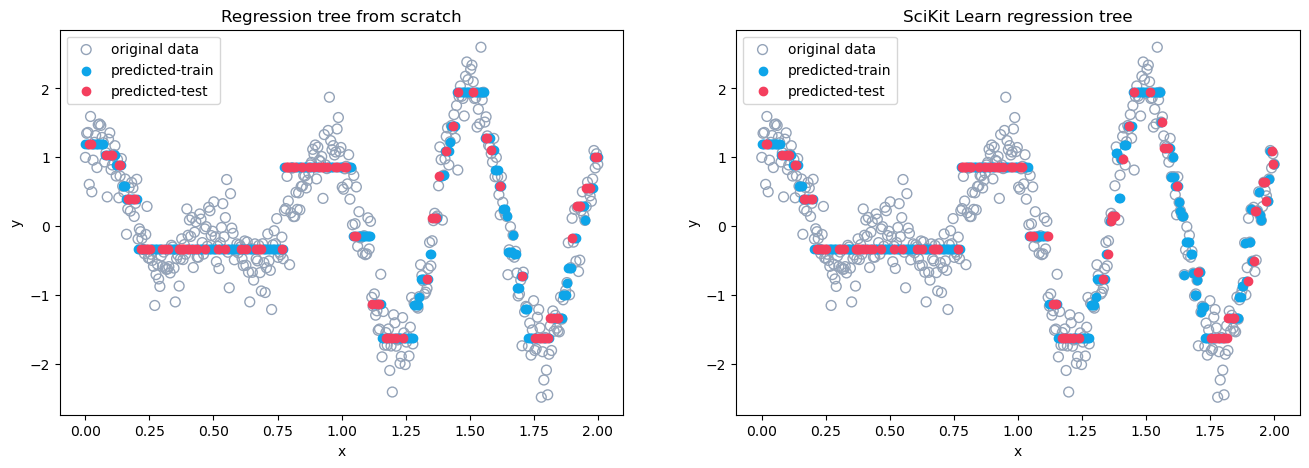

In [17]:
learners = [best_scratch_rdt, best_sklearn_rdt]
titles = ["Regression tree from scratch", "SciKit Learn regression tree"]

fig, axes = plt.subplots(1, 2, figsize=(16,5))

for i in range(2):
    axes[i].scatter(x, y, s=50, facecolors='none', edgecolors='#94a3b8', label="original data")

    # Using training data
    axes[i].scatter(X_train, learners[i].predict(X_train), color='#0ea5e9', label="predicted-train")

    # Using testing data
    axes[i].scatter(X_test, learners[i].predict(X_test), color='#f43f5e', label="predicted-test")

    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    axes[i].set_title(titles[i])
    axes[i].legend()

which might be what we are looking for without risking overfitting.